# <U>Predict house prices: regression</U>

Regression 문제에서, 우리는 가격이나 확률과 같은 연속적인 값을 예측하는것을 목표로 한다. 

이 예제에서는 Boston suburb 지역의 집의 중간 값을 예측하기로 한다. 이를 위하여, 우리는 crime rate와 local property tax rate 같은 suburb에 대한 data point를 사용하여 model을 생성한다.

In [2]:
import tensorflow as tf
from tensorflow import keras

import numpy as np

print(tf.__version__)

1.10.0


# The Boston Housing Prices dataset

In [22]:
boston_housing = keras.datasets.boston_housing

(train_data, train_labels), (test_data, test_labels) = boston_housing.load_data()

# shuffle the training set
order = np.argsort(np.random.random(train_labels.shape))
train_data = train_data[order]
train_labels = train_labels[order]

이 데이터 셋은 총 506 개이며, 404개의 training data와 102개의 test data로 나눈다.

In [23]:
print("Training set: {}".format(train_data.shape))
print("Test set: {}".format(test_data.shape))

Training set: (404, 13)
Test set: (102, 13)


데이터 셋은 다음과 같이 총 13개의 feature를 갖는다.

1. Per capita crime rate.
2. The proportion of residential land zoned for lots over 25,000 square feet.
3. The proportion of non-retail business acres per town.
4. Charles River dummy variable (= 1 if tract bounds river; 0 otherwise).
5. Nitric oxides concentration (parts per 10 million).
6. The average number of rooms per dwelling.
7. The proportion of owner-occupied units built before 1940.
8. Weighted distances to five Boston employment centers.
9. Index of accessibility to radial highways.
10. Full-value property-tax rate per $10,000.
11. Pupil-teacher ratio by town.
12. 1000 * (Bk - 0.63) ** 2 where Bk is the proportion of Black people by town.
13. Percentage lower status of the population.

각 feature는 모두 다른 Scale을 갖는 데이터 이므로, 이 값들을 학습에 사용하기 위해서는 정리 해줄 필요가 있다.

In [24]:
print(train_data[0])

[7.8750e-02 4.5000e+01 3.4400e+00 0.0000e+00 4.3700e-01 6.7820e+00
 4.1100e+01 3.7886e+00 5.0000e+00 3.9800e+02 1.5200e+01 3.9387e+02
 6.6800e+00]


`pandas`를 사용하여, formatted table 로 data 의 첫번째 줄을 표시해보자.

In [25]:
import pandas as pd

column_names = ['CRIM', 'ZN', 'INDUS', 'CHAS', 'NOX', 'RM', 'AGE', 'DIS', 'RAD',
                'TAX', 'PTRATIO', 'B', 'LSTAT']

df = pd.DataFrame(train_data, columns=column_names)
df.head()

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT
0,0.07875,45.0,3.44,0.0,0.437,6.782,41.1,3.7886,5.0,398.0,15.2,393.87,6.68
1,4.55587,0.0,18.10,0.0,0.718,3.561,87.9,1.6132,24.0,666.0,20.2,354.70,7.12
2,0.09604,40.0,6.41,0.0,0.447,6.854,42.8,4.2673,4.0,254.0,17.6,396.90,2.98
3,0.01870,85.0,4.15,0.0,0.429,6.516,27.7,8.5353,4.0,351.0,17.9,392.43,6.36
4,0.52693,0.0,6.20,0.0,0.504,8.725,83.0,2.8944,8.0,307.0,17.4,382.00,4.63


Label은 1000 달러 단위의 House price 이다.

In [26]:
print(train_labels[0:10])

[32.  27.5 32.  23.1 50.  20.6 22.6 36.2 21.8 19.5]


## <U>Normalize features</U>

각 다른 scale의 feature를 Normalization하는 방법은 각 feature의 Mean을 빼고, standard deviation 값으로 나눠주는 것이다. 

In [27]:
# 여기서 test set은 사용하지 않는다.

mean = train_data.mean(axis=0)
std = train_data.std(axis=0)
train_data = (train_data - mean)/std
test_data = (test_data - mean)/std

print(train_data[0])

[-0.39725269  1.41205707 -1.12664623 -0.25683275 -1.027385    0.72635358
 -1.00016413  0.02383449 -0.51114231 -0.04753316 -1.49067405  0.41584124
 -0.83648691]


Feature normalizatio 없이도 Model은 converge할 수 있으나, training을 더 어렵게 만들 수 있으며, 더욱 사용된 input data 에 dependent하게 된다.

## <U>Create the model</U>

모델은 `Sequential`을 사용하여 2개의 dense connected hidden layers를 사용할 것이다. output layer는 single, continuous value를 리턴할 것이다. 

In [10]:
def build_model():
    model = keras.Sequential([
        keras.layers.Dense(64, activation=tf.nn.relu,
                          input_shape=(train_data.shape[1],)),
        keras.layers.Dense(64, activation=tf.nn.relu),
        keras.layers.Dense(1)
    ])
    
    optimizer = tf.train.RMSPropOptimizer(0.001)
    
    model.compile(loss='mse',
                 optimizer=optimizer,
                 metrics=['mae'])
    return model

model = build_model()
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 64)                896       
_________________________________________________________________
dense_1 (Dense)              (None, 64)                4160      
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 65        
Total params: 5,121
Trainable params: 5,121
Non-trainable params: 0
_________________________________________________________________


## <U>Train the model</U>

In [12]:
#  각 완료된 epoch 마다 single dot 을 출력해서 학습 진행상황을 표시
class PrintDot(keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs):
        if epoch % 100 == 0: print('')
        print('.', end='')

EPOCHS = 500

# Store training stats
history = model.fit(train_data, train_labels, epochs=EPOCHS,
                    validation_split=0.2, verbose=0,
                    callbacks=[PrintDot()])


....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................

`history` object에 저장된 stats 를 시각화 해보자. 

In [13]:
import matplotlib.pyplot as plt 
%matplotlib inline

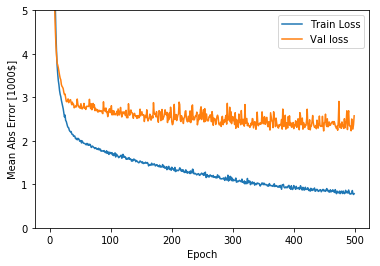

In [14]:
def plot_history(history):
    plt.figure()
    plt.xlabel('Epoch')
    plt.ylabel('Mean Abs Error [1000$]')
    plt.plot(history.epoch, np.array(history.history['mean_absolute_error']), 
            label='Train Loss')
    plt.plot(history.epoch, np.array(history.history['val_mean_absolute_error']),
            label = 'Val loss')
    plt.legend()
    plt.ylim([0, 5])
    
plot_history(history)

이 그래프 상으로 봤을때 200 epoch 이후에서는 더이상의 큰 개선이 없어 보인다. `model.fit` method를 업데이트해서 validation score 가 더이상 개선되지 않을때 학습을 멈추도록 업데이트 해보자. 

각 epoch 당 training condition을 체크하도록 *callback* 함수를 사용하면 된다. 


....................................................................................................
....................................................................................................
..........................................................................

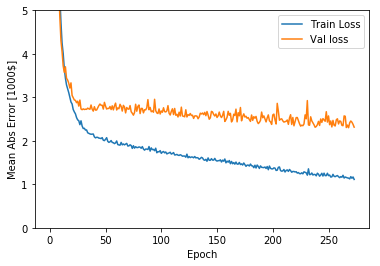

In [16]:
model = build_model()

early_stop = keras.callbacks.EarlyStopping(monitor='val_loss', patience=20)
history = model.fit(train_data, train_labels, epochs=EPOCHS,
                   validation_split=0.2, verbose=0,
                   callbacks=[early_stop, PrintDot()])

plot_history(history)

이제 test set에서 model 을 확인해보자

In [29]:
[loss, mae] = model.evaluate(test_data, test_labels, verbose=0)

print("Testing set Mean Abs Error: ${:7.2f}".format(mae * 1000))

Testing set Mean Abs Error: $2789.04


## <U>Predict</U>

testing set에 있는 data를 사용해서 housing price 를 predict 해보자

In [30]:
test_predictions = model.predict(test_data).flatten()

print(test_predictions)

[ 7.8099174 19.164583  20.309114  35.67233   24.369074  21.911772
 24.887989  21.32984   18.50656   20.024475  21.499598  16.405678
 15.367655  42.056713  19.904661  18.79902   23.109764  17.186369
 19.327703  24.716772  11.875679  11.049404  19.808603  15.059887
 19.18854   24.563532  28.45934   27.500217  10.456715  17.792826
 19.164022  15.524818  31.457838  21.624245  19.855503   8.587242
 17.195705  16.74985   17.883581  25.015787  30.521841  27.190973
 14.36652   40.652573  29.191837  25.354404  27.819462  17.707565
 21.973738  21.199299  33.64366   20.894115  10.953233  13.886807
 33.668133  27.340693  11.720837  47.03598   32.97732   23.430891
 21.805466  14.822877  14.416604  19.117798  22.439037  20.380257
 14.479286  20.83407   13.747984   7.2457414 24.576303  27.084164
 26.817133  14.189097  23.280352  19.772825  17.152626  22.612482
 34.22996   10.582573  21.288593  36.802742  15.452177  14.138451
 17.242952  20.220627  21.27268   18.92633   20.451538  28.6589
 20.482904  

# <U>Conclusion</U>

- Mean Squared Error(MSE)는 Regression problem에서 일반적으로 사용되는 loss funciton 이다.
- Regression에서는 Classification과는 다른 Evaluation Metric을 사용해야 하는데 일반적으로 Mean Absolute Error(MAE)를 사용한다.
- Input data feature들이 다른 range를 갖고 있다면, 각 feature들은 각각 scaling을 해주어야 한다. 
- training data가 많지 않다면, overfitting을 피하기 위하여 적은 hidden layer를 갖는 small network를 사용한다.
- Early Stopping은 overfitting을 줄일 수 있는 유용한 technique이다. 